<a href="https://colab.research.google.com/github/Daniel-Francisco-Calderon-Lebro/Vision_por_Computador/blob/main/Segmentacion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import cv2 as cv
from google.colab.patches import cv2_imshow # para visualizar imágenes
from skimage import io
from PIL import Image
import matplotlib.pylab as plt
%matplotlib inline


ruta = '/content/drive/MyDrive/Vision por computador/'
Max_level = 255
r = np.linspace(0,Max_level,Max_level+1) # posibles entradas


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Segmentos

Son las regiones que componen una imagen y que al juntarse la reconstruyen.

![https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSehp7h-hjM_9KWKOwjPpghuEkmwf6ianrT-XhjWsUf5VzyWP9ukV2NYHoEzeaxrwTMpP8&usqp=CAU](https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSehp7h-hjM_9KWKOwjPpghuEkmwf6ianrT-XhjWsUf5VzyWP9ukV2NYHoEzeaxrwTMpP8&usqp=CAU)



## Umbralización

Se separan las entidades según superen o no un umbral $th$.

$$I_s>th$$

![https://svi.nl/wikiimg/SeedAndThreshold_02.png](https://svi.nl/wikiimg/SeedAndThreshold_02.png)

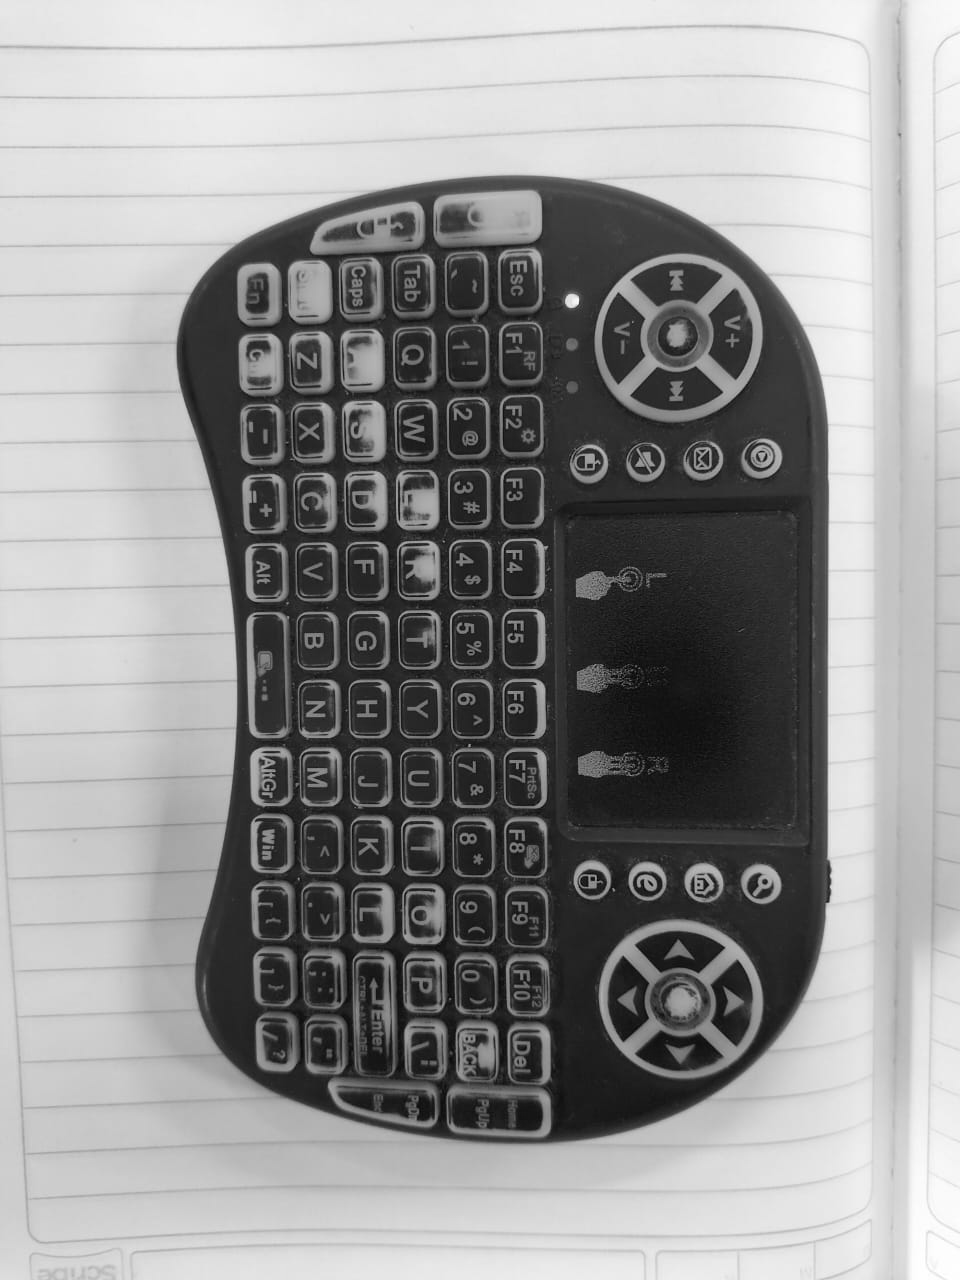

In [ ]:
 img = io.imread(ruta + 'Teclado1.jpeg') # Lee imagen
img = cv.cvtColor(img, cv.COLOR_BGR2GRAY) # Convierte imagen a tonos de gris
cv2_imshow(img)

 th = 120


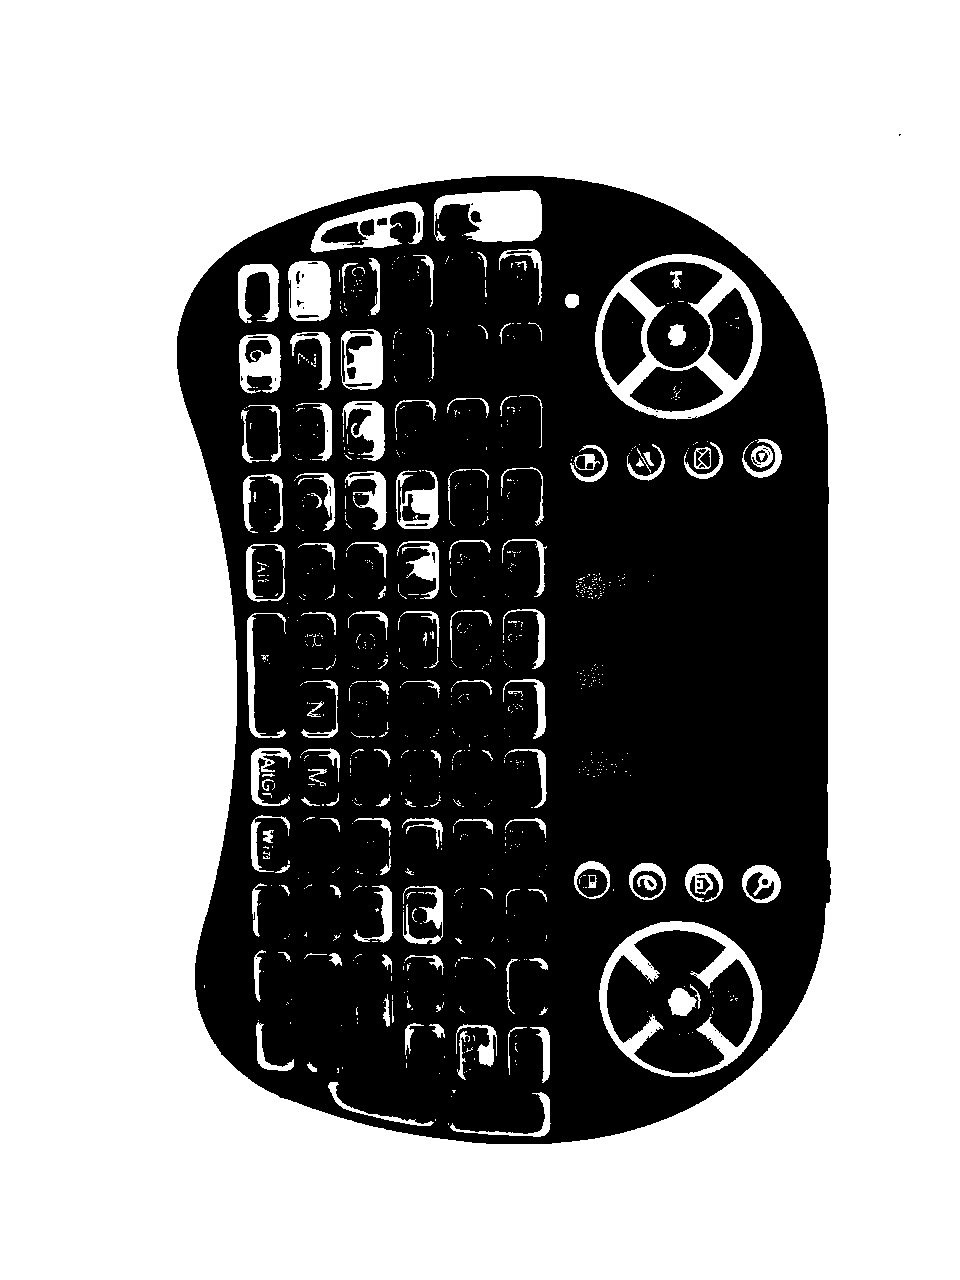

In [ ]:
th1 = 120
_, seg1 = cv.threshold(img, th1, Max_level, cv.THRESH_BINARY+cv.THRESH_OTSU)
print(' th = '+ str(th1))
cv2_imshow(seg1)

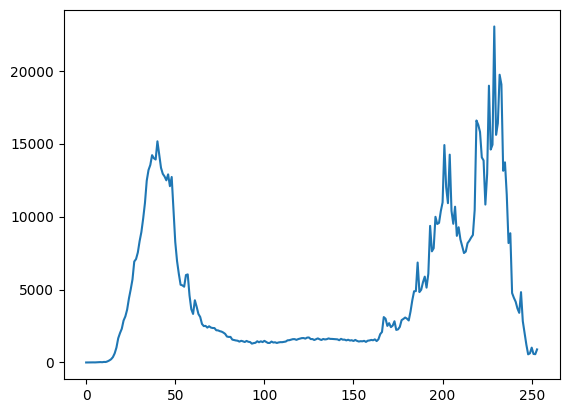

In [ ]:
img_hist = cv.calcHist([img],[0],None,[Max_level+1],[0,256])
plt.plot(r[:-2],img_hist[:-2])

- ¿Cómo se puede mejorar la imagen?
- ¿Cómo se puede definir mejor el umbral?


- PREPROCESAMIENTO

In [ ]:
d = 5
img_g00 = cv.GaussianBlur(img,(d,d),0)

Original


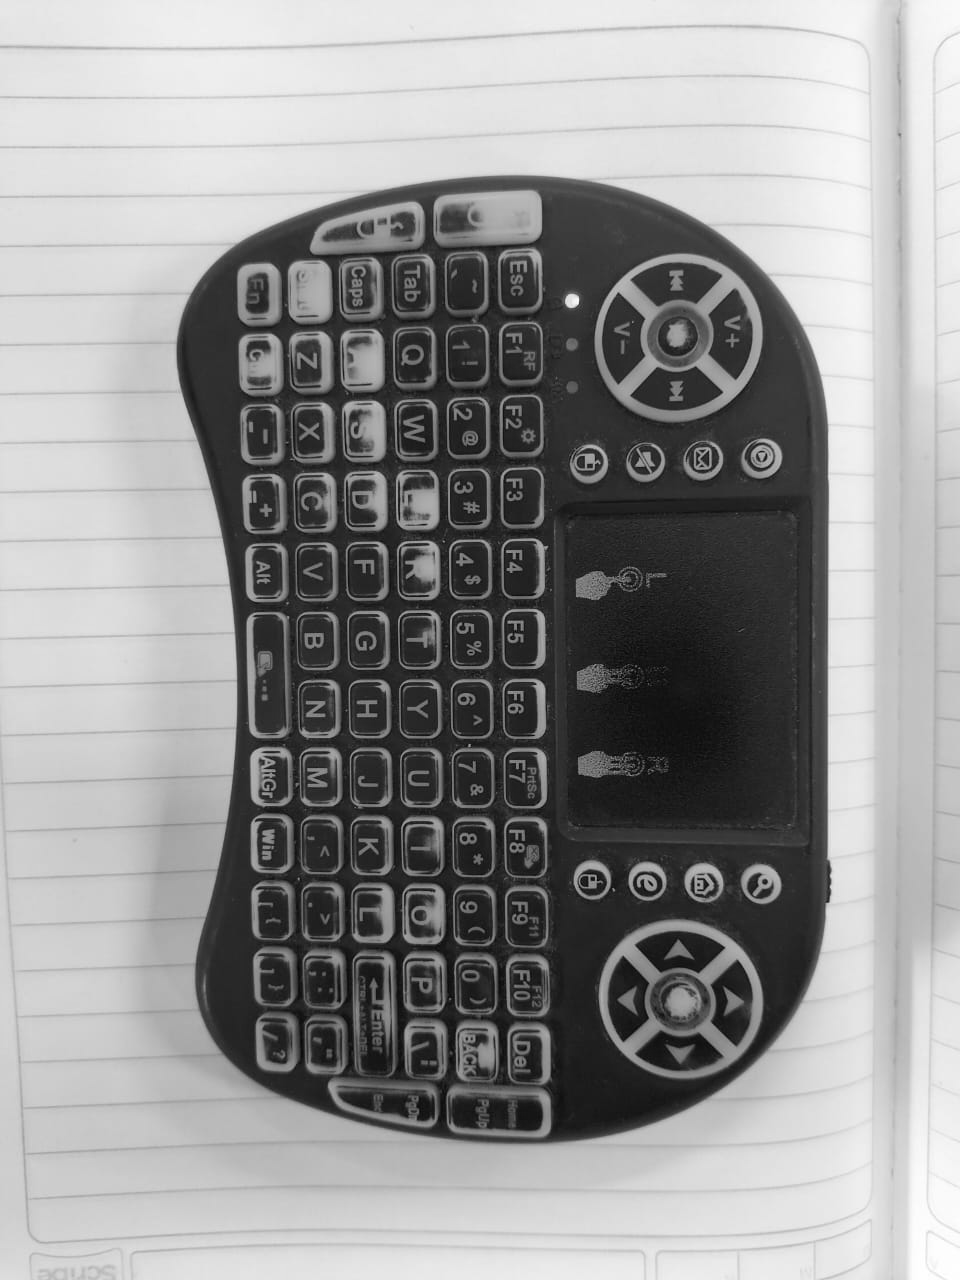

In [ ]:
print('Original')
cv2_imshow(img)

Suavizada


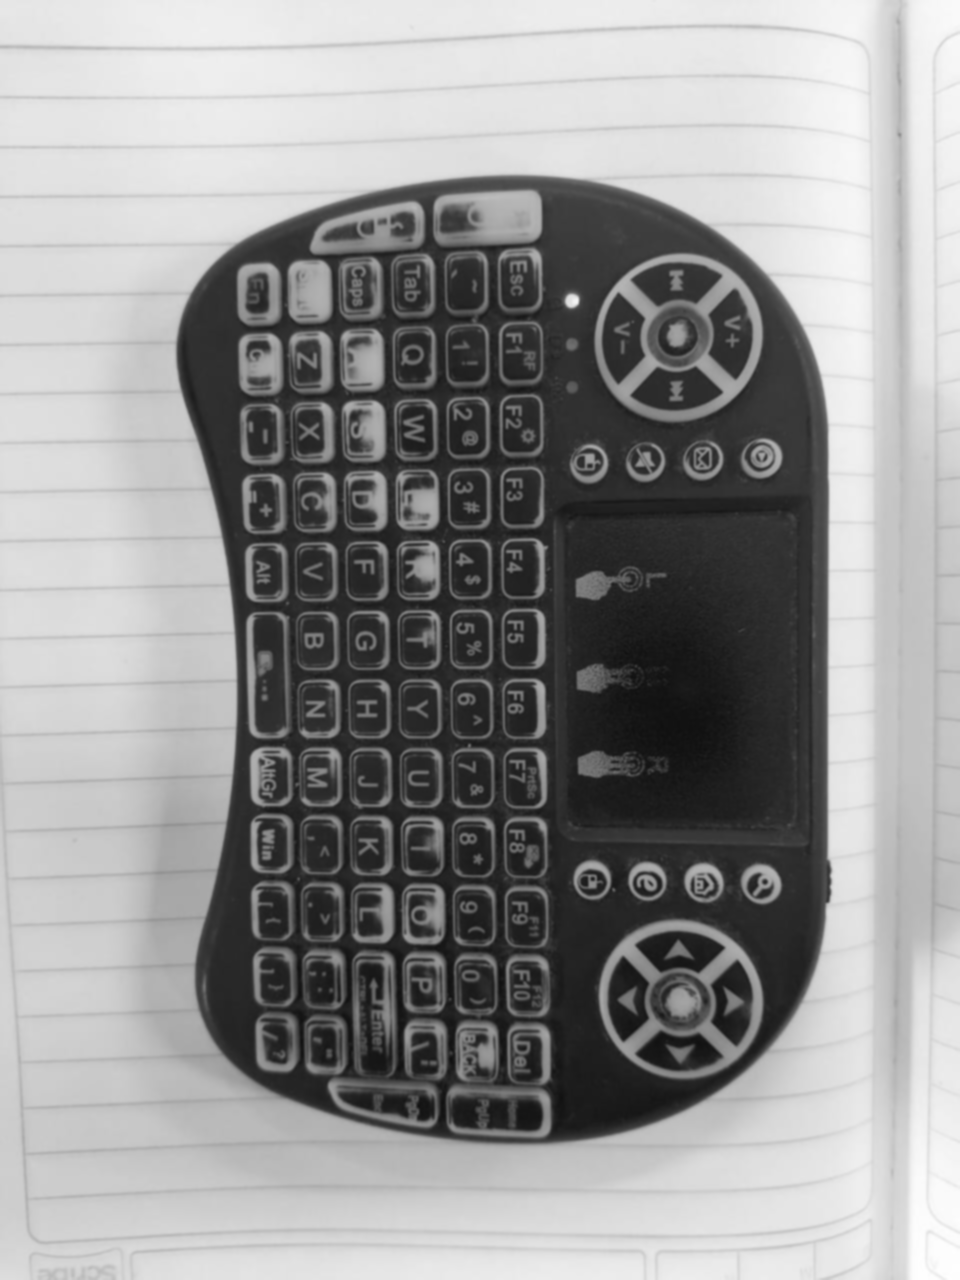

In [ ]:
print('Suavizada')
cv2_imshow(img_g00)

- **Filtro High Boost**

Combina la información de baja frecuencia con la de alta.

$$
A\begin{bmatrix}
 0 & 0 & 0\\
 0 & 1 & 0\\
 0 & 0 & 0
\end{bmatrix} +
\begin{bmatrix}
 -1 & -1 & -1\\
 -1 & 8 & -1\\
 -1 & -1 & -1
\end{bmatrix}
= \begin{bmatrix}
 -1 & -1 & -1\\
 -1 & 8+A & -1\\
 -1 & -1 & -1
\end{bmatrix}
$$

Gauss + HB + A= 1


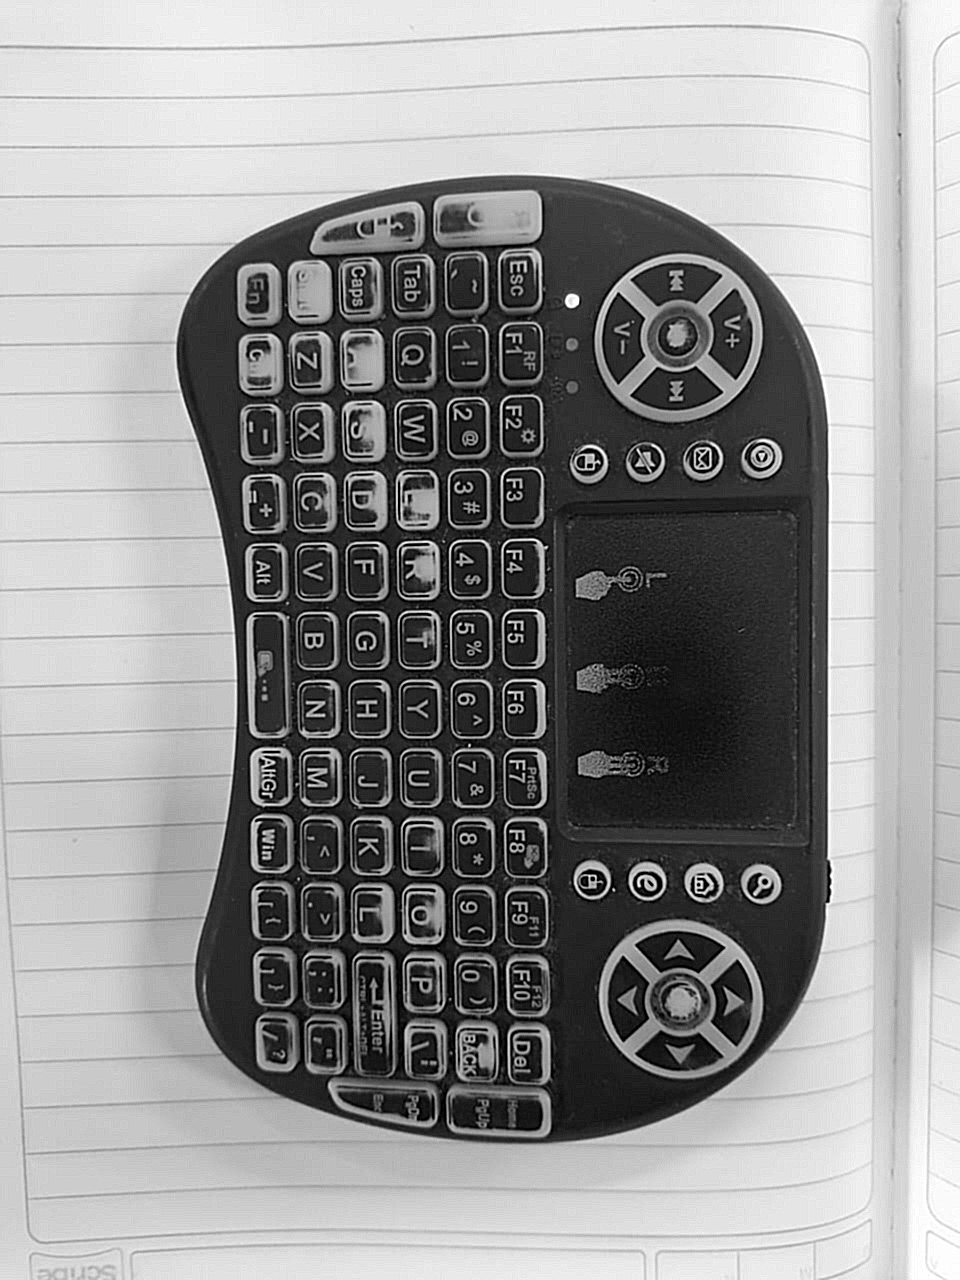

In [ ]:
A = 1
filtroHB = np.array([[-1,-1,-1],
                     [-1,8+A,-1],
                     [-1,-1,-1]])
imgHB = cv.filter2D(img_g00,-1, filtroHB)# Hay parámetros extra
print('Gauss + HB + A=',A)
cv2_imshow(imgHB)

In [ ]:
img_hist = cv.calcHist([img],[0],None,[Max_level+1],[0,256])
imgHB_hist = cv.calcHist([imgHB],[0],None,[Max_level+1],[0,256])
imgHB_hist_cum = np.cumsum(imgHB_hist)

imgHB_hist_cum = np.round( Max_level*(imgHB_hist_cum - min(imgHB_hist_cum))/( max(imgHB_hist_cum) -  min(imgHB_hist_cum)));
LUT_eqcum = np.where( imgHB_hist_cum<0,0,
                     np.where(imgHB_hist_cum>255,255,imgHB_hist_cum)).astype(np.uint8)
imgHB_eqHist = cv.LUT(imgHB, LUT_eqcum)
imgHB_eqHist_hist = cv.calcHist([imgHB_eqHist],[0],None,[Max_level+1],[0,256])


Original


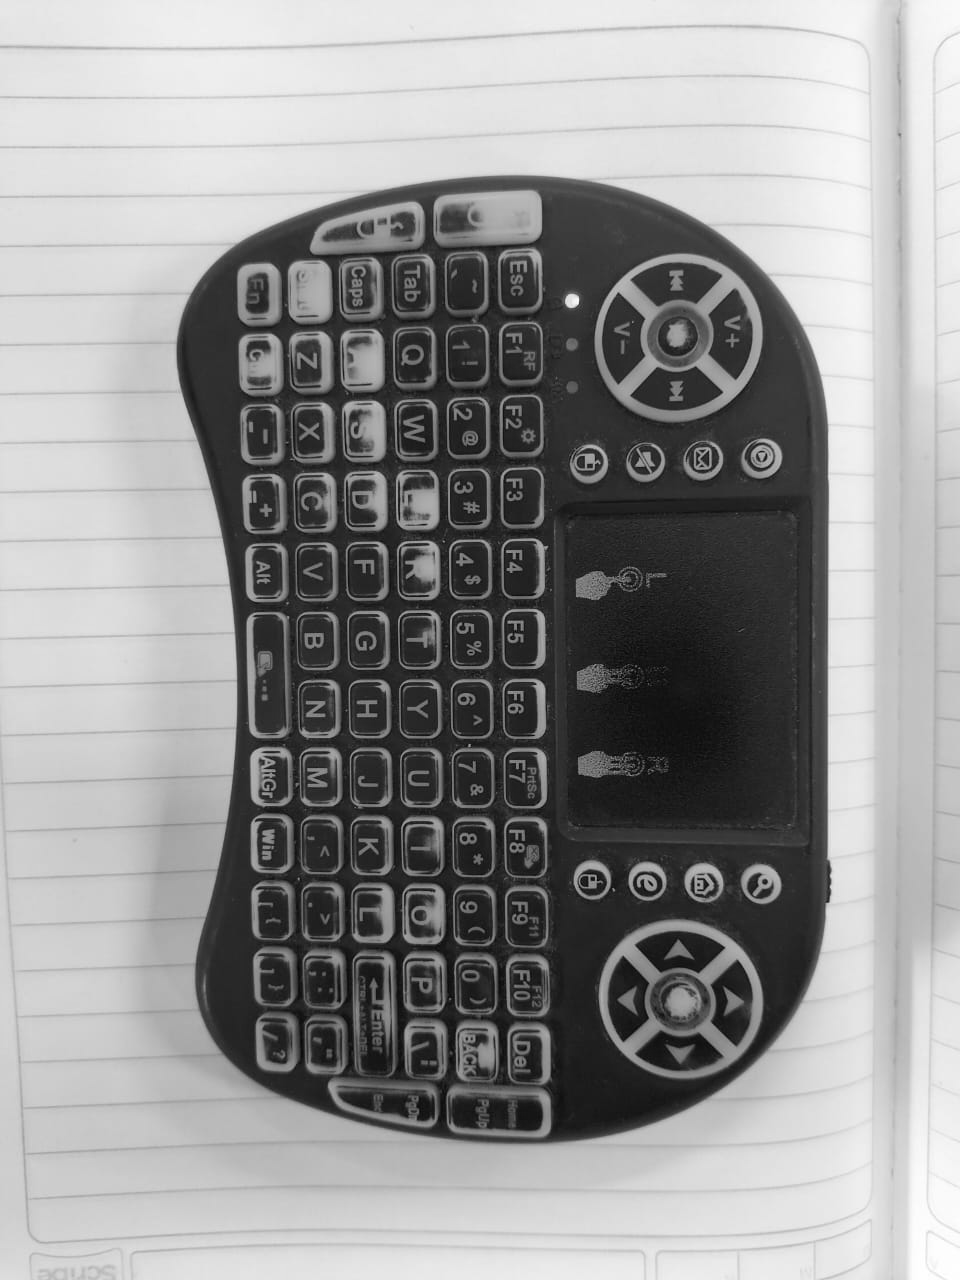

Gauss + HB


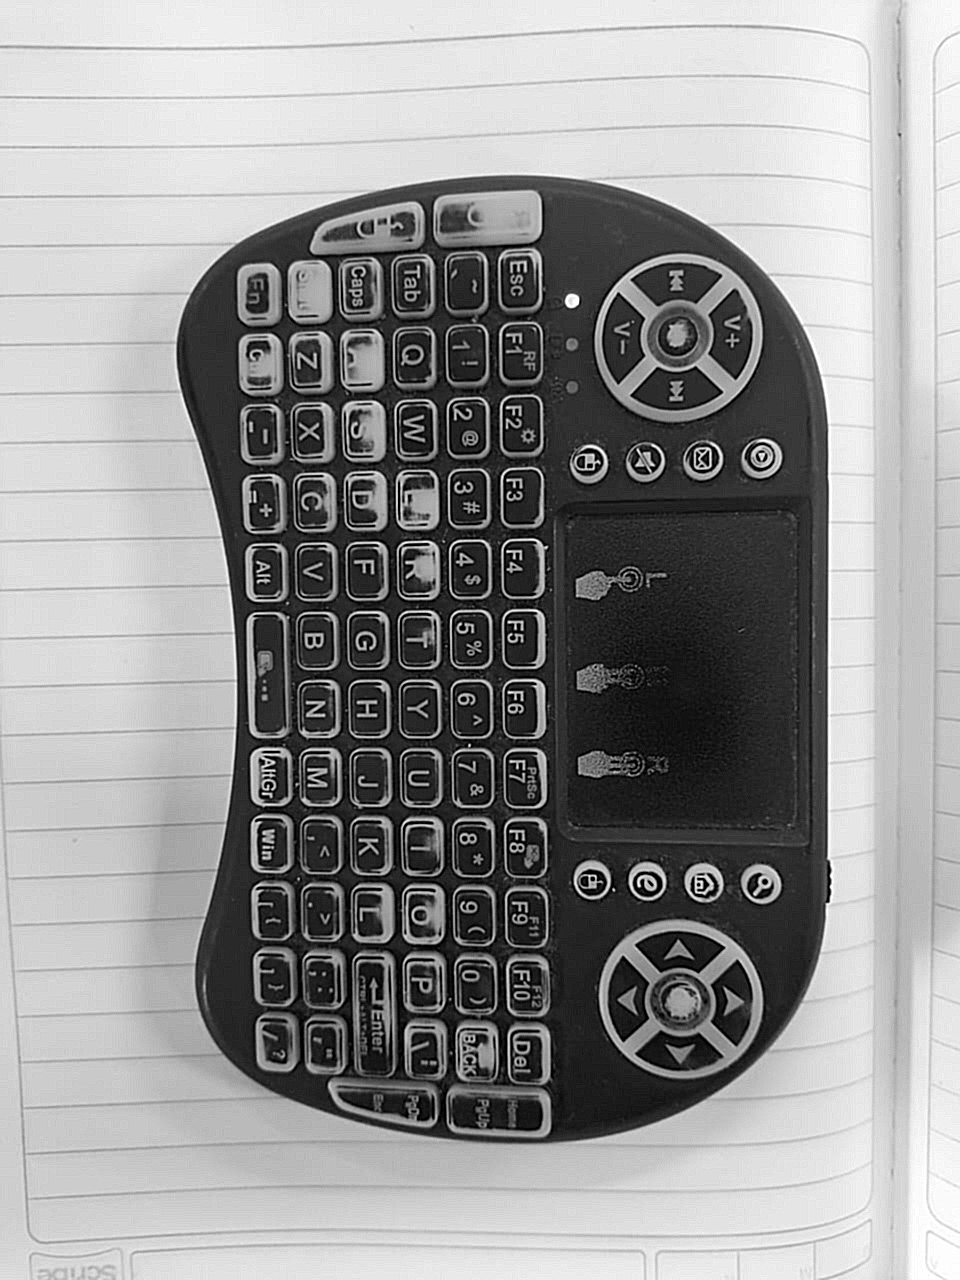

(0.0, 2000.0)

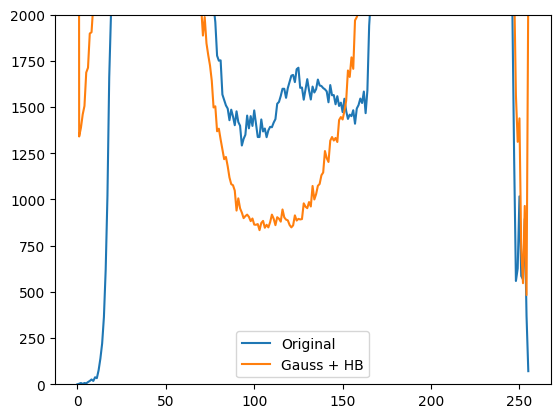

In [ ]:
from matplotlib import legend
print('Original')
cv2_imshow(img)
print('Gauss + HB')
cv2_imshow(imgHB)

img_hist_cum = np.cumsum(img_hist)
plt.plot(r,img_hist,r,imgHB_hist)
plt.legend({'Original','Gauss + HB'})
plt.ylim([0,2000])


- Analizando el histograma original se nota el porqué de los malos resultados con $th=50$ en la imagen original.
- Con los parámetros hasta el momento, $th=100$ parece buena opción para la imagen mejorada.

**Método de OTSU**

Se usa con imágenes bimodales y se encarga de encontrar en umbral $th$ que minimice la varianza dentro de las clases.

![https://miro.medium.com/v2/resize:fit:1100/format:webp/1*mpd4NI3g7XQSVOuegE7VIg.png](https://miro.medium.com/v2/resize:fit:1100/format:webp/1*mpd4NI3g7XQSVOuegE7VIg.png)

![https://miro.medium.com/v2/resize:fit:622/format:webp/1*HpvS90bwsFMz-4XBQpp7_A.png](https://miro.medium.com/v2/resize:fit:622/format:webp/1*HpvS90bwsFMz-4XBQpp7_A.png)

![https://miro.medium.com/v2/resize:fit:1100/format:webp/1*GQNVs_s3g9QshW3uco7dvA.png](https://miro.medium.com/v2/resize:fit:1100/format:webp/1*GQNVs_s3g9QshW3uco7dvA.png)

In [ ]:
th2,seg2 = cv.threshold(imgHB,0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)
th2

125.0

 th = 120


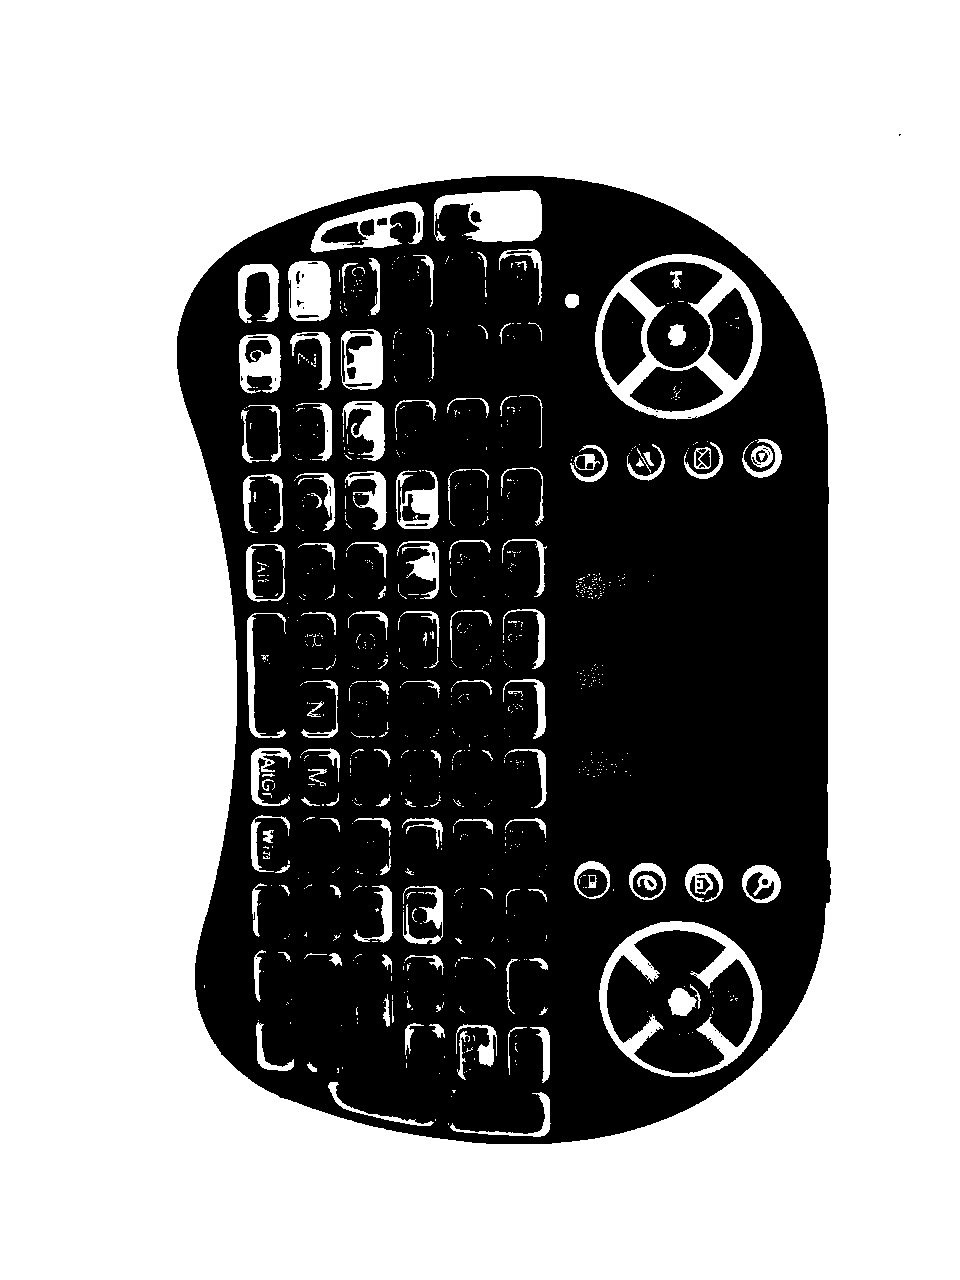

OTSU


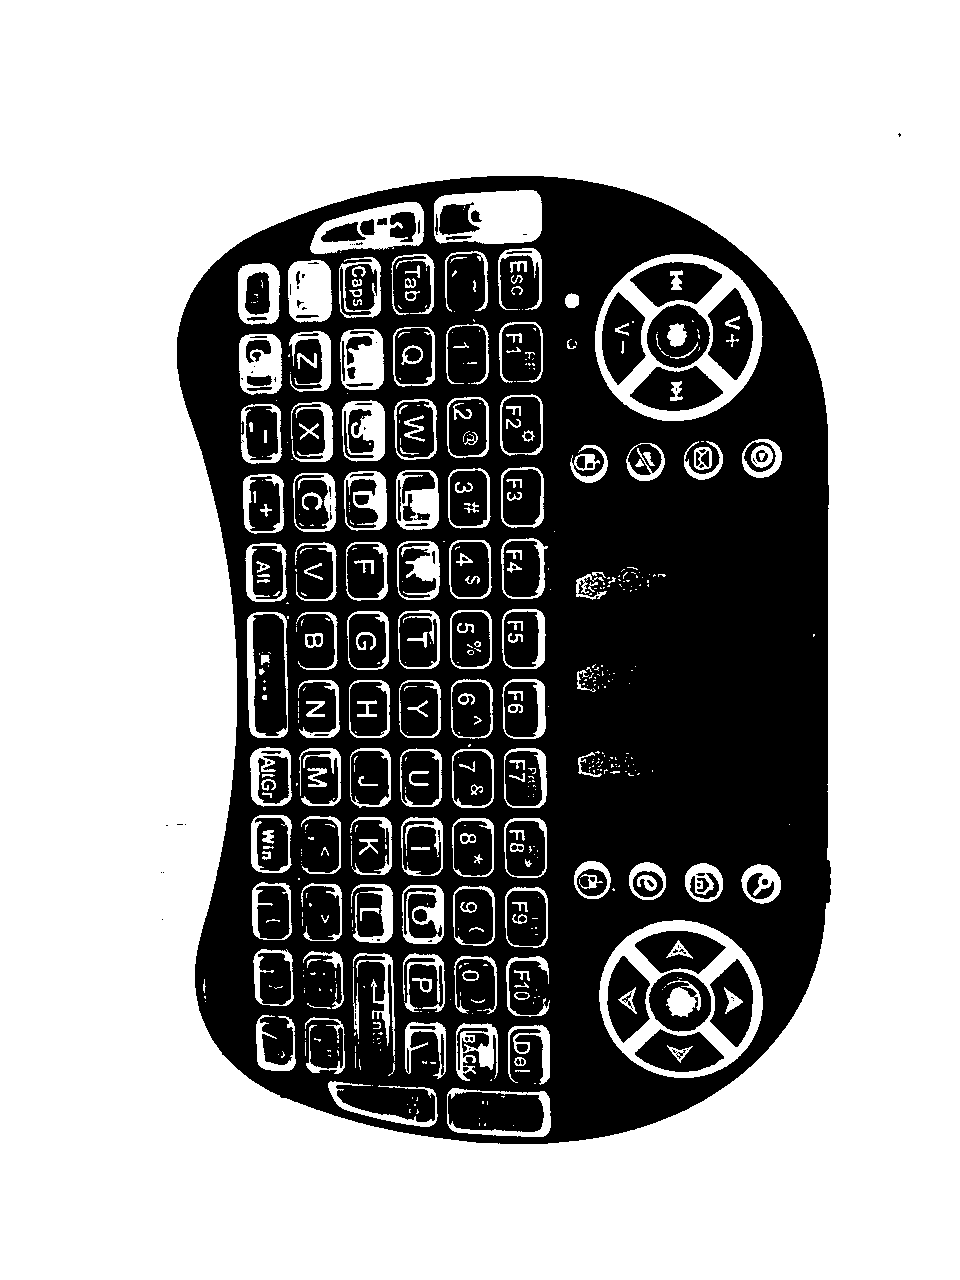

In [ ]:
print(' th = '+ str(th1))
cv2_imshow(seg1)
print('OTSU')
cv2_imshow(seg2)

Un preprocesamiento habitual es restar el fondo de iluminación dispareja $I_f$ de la imagen $I$.

$$I_o=I-I_f$$

Este fondo se estima:
- Al filtrar la imagen con un filtro de suavizado tal que deje "borrosa" la imagen.
- Al aplicar una operación de apertura con un kernel apropiado.

[https://docs.opencv.org/4.x/d9/d61/tutorial_py_morphological_ops.html](https://docs.opencv.org/4.x/d9/d61/tutorial_py_morphological_ops.html)


- Escriba su código para detectar las regiones que cumplan la condición según la cual

$$I>I_f$$

Puede usar np.where

 th = 0


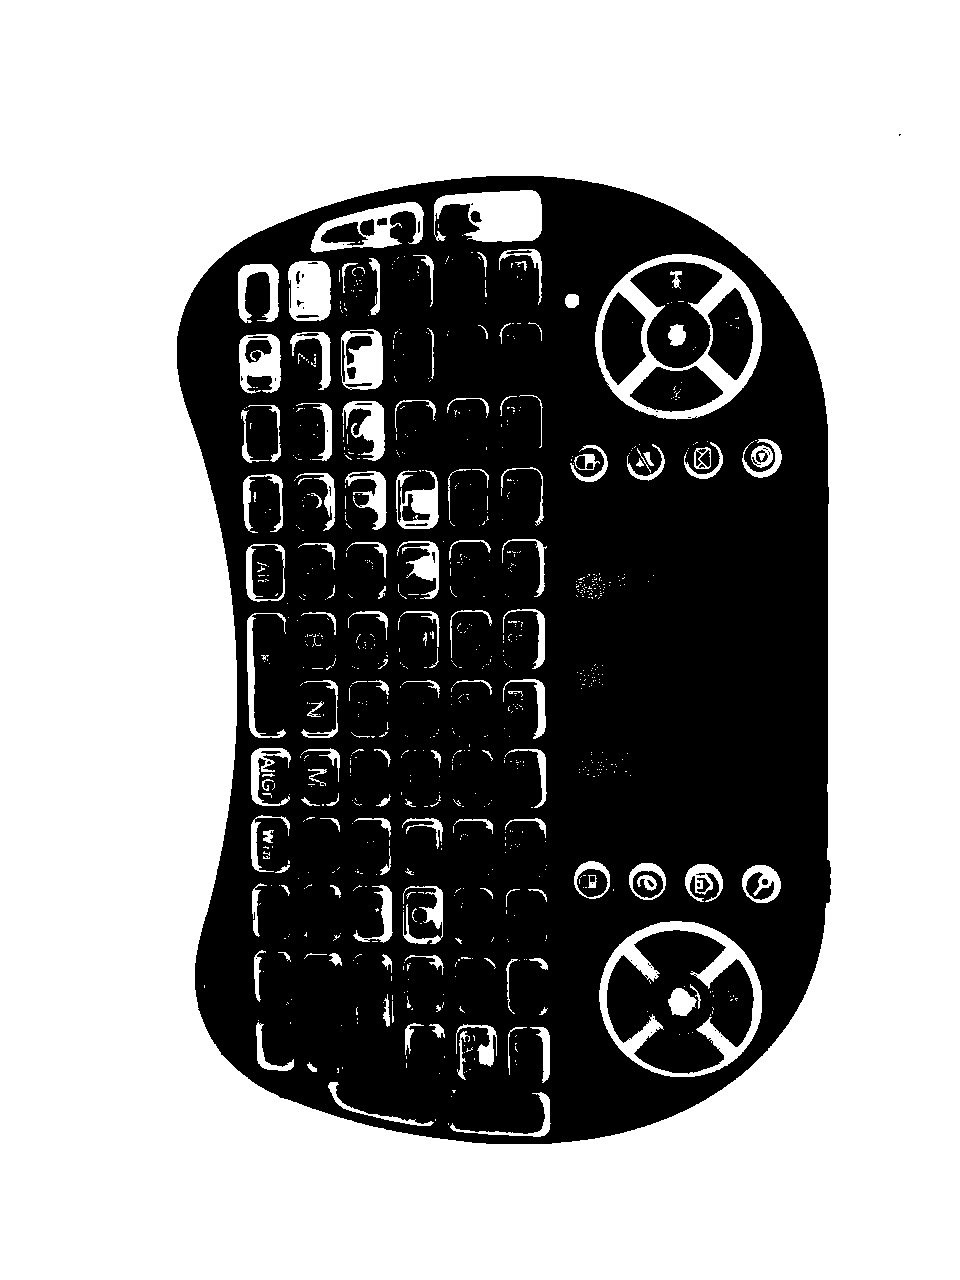

In [ ]:
th1 = 0
_, seg1 = cv.threshold(img, th1, Max_level, cv.THRESH_BINARY+cv.THRESH_OTSU)
print(' th = '+ str(th1))
cv2_imshow(seg1)

In [ ]:
# Supongamos que 'seg2' es tu imagen segmentada
labels= cv.connectedComponentsWithStats(seg2, connectivity=4)
# Número total de componentes conectados
numero_componentes = labels[0]

# Etiquetas de los componentes conectados
etiquetas = labels[1]

# Estadísticas de cada componente conectado
estadisticas = labels[2]

# Centroides de los componentes conectados
centroides = labels[3]

In [ ]:
numero_componentes
print(numero_componentes)

645


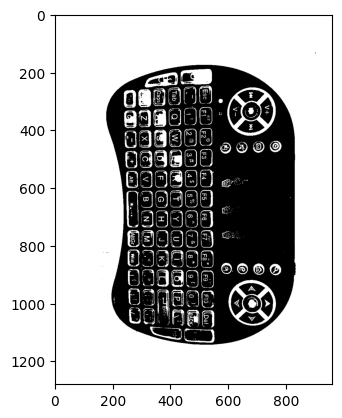

In [ ]:
plt.imshow(seg2, cmap='gray')

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]], dtype=int32)

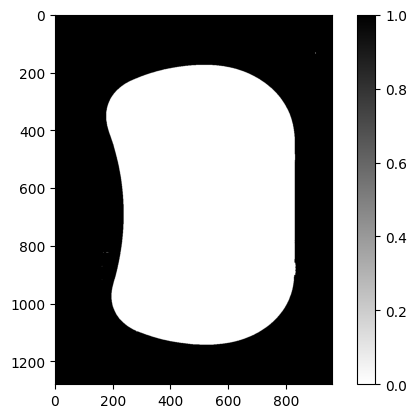

In [ ]:
plt.imshow(etiquetas==1, cmap='gray_r')
plt.colorbar()
etiquetas

In [ ]:
estadisticas

array([[   161,    133,    740,   1011, 457228],
       [     0,      0,    960,   1280, 681306],
       [   434,    190,    108,     54,   4243],
       ...,
       [   479,   1123,      1,      3,      3],
       [   484,   1123,      2,      3,      5],
       [   513,   1125,      1,      1,      1]], dtype=int32)

In [ ]:
centroides

array([[ 521.14700543,  664.92784563],
       [ 452.8966485 ,  624.93296111],
       [ 496.40136696,  216.05844921],
       ...,
       [ 479.        , 1124.        ],
       [ 484.6       , 1124.2       ],
       [ 513.        , 1125.        ]])

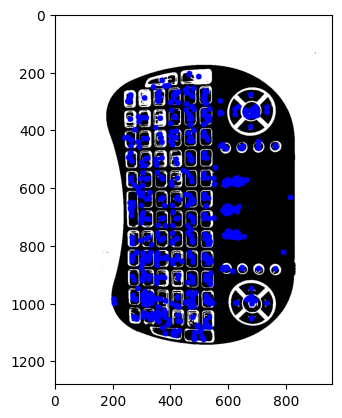

In [ ]:
# Supongamos que 'seg2' es tu imagen segmentada
labels = cv.connectedComponentsWithStats(seg2, connectivity=4)

# Centroides de los componentes conectados
centroides = labels[3]

# Crear una imagen en blanco para dibujar los centroides
imagen_con_centroides = cv.cvtColor(seg2, cv.COLOR_GRAY2BGR)

# Dibujar los centroides como puntos grandes en la imagen
for centroide in centroides:
    x, y = int(centroide[0]), int(centroide[1])
    cv.circle(imagen_con_centroides, (x, y), 10, (0, 0, 255), -1)  # Dibuja un círculo rojo de radio 10 en el centroide

# Mostrar la imagen con los centroides marcados
plt.imshow(imagen_con_centroides, cmap='gray_r')
